# Student GPA Prediction

**Goal:** Build a reproducible notebook that:
- Cleans and preprocesses the dataset
- Performs EDA (matplotlib only)
- Engineers features (if necessary)
- Trains and compares Linear Regression, Decision Tree, Random Forest
- Evaluates using R², MAE, RMSE and cross-validation
- Saves the best model as a Pickle pipeline

In [59]:
# Setup imports and paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from pathlib import Path

# Reproducible seed
RANDOM_STATE = 42

# Paths (change if you keep data elsewhere)
if Path('/content/drive').exists():
    BASE_DIR = Path('/content/drive/MyDrive/Student_Performance_Prediction')
else:
    BASE_DIR = Path('.').resolve()

DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'model'
NOTEBOOKS_DIR = BASE_DIR / 'notebook'
REPORTS_DIR = BASE_DIR / 'reports'

# Make sure directories exist (Colab: create them or upload dataset into data/)
for d in [DATA_DIR, REPORTS_DIR, MODELS_DIR, NOTEBOOKS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / 'Student_performance_dataset.csv'  # ensure your CSV is here or change the path

print("Data path:", DATA_PATH)


Data path: /content/drive/MyDrive/Student_Performance_Prediction/data/Student_performance_dataset.csv


## Load the dataset and quick inspection

We will load the CSV, show shape and top rows to confirm correct loading.


In [48]:
# Load dataset and preview
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Upload Student_performance_dataset.csv to the `data/` folder.")

df = pd.read_csv(DATA_PATH)
print("Raw dataset shape:", df.shape)
display(df.head(10))


Raw dataset shape: (2392, 13)


,StudentID,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,1001,17,1,2,19.833723,7,1,2,0,0,1,0,8.74
1,1002,18,0,1,15.408756,0,0,1,0,0,0,0,8.89
2,1003,15,0,3,4.210570,26,0,2,0,0,0,0,2.14
3,1004,17,1,3,10.028829,14,0,3,1,0,0,0,7.50
4,1005,17,1,2,4.672495,17,1,3,0,0,0,0,6.13
5,1006,18,0,1,8.191219,0,0,1,1,0,0,0,8.94
6,1007,15,0,1,15.601680,10,0,3,0,1,0,0,8.51
7,1008,15,1,4,15.424496,22,1,1,1,0,0,0,6.28
8,1009,17,0,0,4.562008,1,0,2,0,1,0,1,8.70
9,1010,16,1,1,18.444466,0,0,3,1,0,0,0,9.53


## Data cleaning plan

Steps:
- Drop StudentID (not useful for prediction)
- Coerce dtypes safely
- Impute missing values: median for numeric, mode for categorical/binary
- Clip GPA to [0, 10] and round to 2 decimals
- Ensure expected columns exist (fail early if not)


In [49]:
# Data cleaning & preprocessing (robust)
df_clean = df.copy()

# Drop duplicates if any
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

# Drop StudentID if exists
if 'StudentID' in df_clean.columns:
    df_clean = df_clean.drop(columns=['StudentID'])

# Expected columns
expected_cols = [
    'Age','Gender','ParentalEducation','StudyTimeWeekly','Absences','Tutoring',
    'ParentalSupport','Extracurricular','Sports','Music','Volunteering','GPA'
]
missing = [c for c in expected_cols if c not in df_clean.columns]
if missing:
    raise ValueError("Missing expected columns: " + ", ".join(missing))

# Coerce types robustly
int_cols = ['Age','Gender','ParentalEducation','Absences','Tutoring','ParentalSupport',
            'Extracurricular','Sports','Music','Volunteering']
for c in int_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').astype('float').astype('Int64')

df_clean['StudyTimeWeekly'] = pd.to_numeric(df_clean['StudyTimeWeekly'], errors='coerce')
df_clean['GPA'] = pd.to_numeric(df_clean['GPA'], errors='coerce')

# Impute
numeric_impute = ['Age','StudyTimeWeekly','Absences','GPA']
for c in numeric_impute:
    if df_clean[c].isnull().any():
        df_clean[c].fillna(df_clean[c].median(), inplace=True)

cat_impute = ['Gender','ParentalEducation','Tutoring','ParentalSupport','Extracurricular','Sports','Music','Volunteering']
for c in cat_impute:
    if df_clean[c].isnull().any():
        df_clean[c].fillna(df_clean[c].mode().iloc[0], inplace=True)

# Clip and round GPA
df_clean['GPA'] = df_clean['GPA'].clip(0,10).round(2)

# Final check
print("Cleaned dataset shape:", df_clean.shape)
display(df_clean.head(8))


Cleaned dataset shape: (2392, 12)


,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,17,1,2,19.833723,7,1,2,0,0,1,0,8.74
1,18,0,1,15.408756,0,0,1,0,0,0,0,8.89
2,15,0,3,4.210570,26,0,2,0,0,0,0,2.14
3,17,1,3,10.028829,14,0,3,1,0,0,0,7.50
4,17,1,2,4.672495,17,1,3,0,0,0,0,6.13
5,18,0,1,8.191219,0,0,1,1,0,0,0,8.94
6,15,0,1,15.601680,10,0,3,0,1,0,0,8.51
7,15,1,4,15.424496,22,1,1,1,0,0,0,6.28


## Exploratory Data Analysis (EDA)

We'll:
- See GPA distribution
- StudyTimeWeekly vs GPA (scatter + linear fit)
- Absences vs GPA (scatter + linear fit)
- GPA by ParentalEducation (boxplot)
- Correlation matrix (numeric features)
All plots saved to the `reports/` directory.


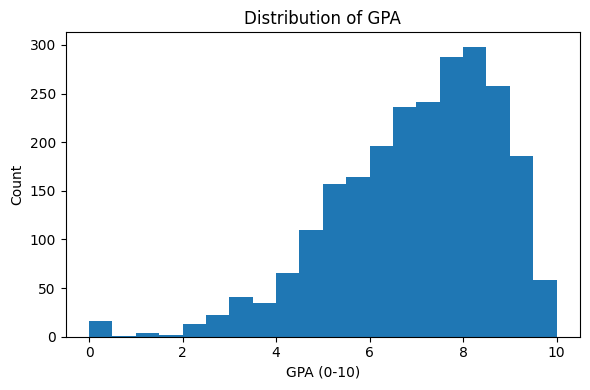

In [50]:
# EDA
reports = REPORTS_DIR
reports.mkdir(exist_ok=True)

# 1. GPA distribution
plt.figure(figsize=(6,4))
plt.hist(df_clean['GPA'].astype(float), bins=20)
plt.xlabel('GPA (0-10)'); plt.ylabel('Count'); plt.title('Distribution of GPA')
plt.tight_layout()
plt.savefig(reports/'gpa_distribution.png')
plt.show()
plt.close()

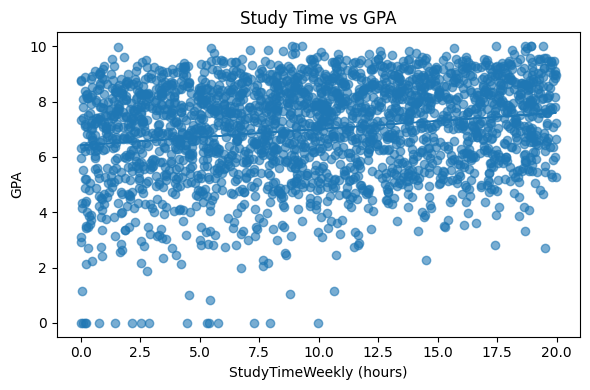

In [51]:
# 2. StudyTimeWeekly vs GPA (scatter + linear fit)
x = df_clean['StudyTimeWeekly'].astype(float).to_numpy()
y = df_clean['GPA'].astype(float).to_numpy()
mask = (~np.isnan(x)) & (~np.isnan(y))
if mask.sum() > 1:
    coef = np.polyfit(x[mask], y[mask], 1)
    line = np.polyval(coef, x)
else:
    line = np.zeros_like(x)

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, line, linewidth=1)
plt.xlabel('StudyTimeWeekly (hours)'); plt.ylabel('GPA'); plt.title('Study Time vs GPA')
plt.tight_layout()
plt.savefig(reports/'studytime_vs_gpa.png')
plt.show()
plt.close()

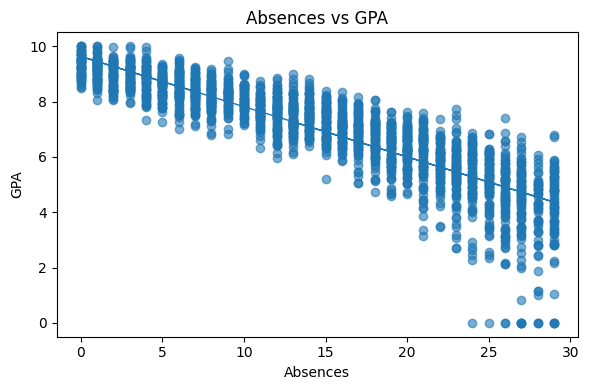

In [52]:
# 3. Absences vs GPA
x2 = df_clean['Absences'].astype(float).to_numpy()
mask2 = (~np.isnan(x2)) & (~np.isnan(y))
if mask2.sum() > 1:
    coef2 = np.polyfit(x2[mask2], y[mask2], 1)
    line2 = np.polyval(coef2, x2)
else:
    line2 = np.zeros_like(x2)

plt.figure(figsize=(6,4))
plt.scatter(x2, y, alpha=0.6)
plt.plot(x2, line2, linewidth=1)
plt.xlabel('Absences'); plt.ylabel('GPA'); plt.title('Absences vs GPA')
plt.tight_layout()
plt.savefig(reports/'absences_vs_gpa.png')
plt.show()
plt.close()

/tmp/ipython-input-3002425419.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(i) for i in range(0,5)])


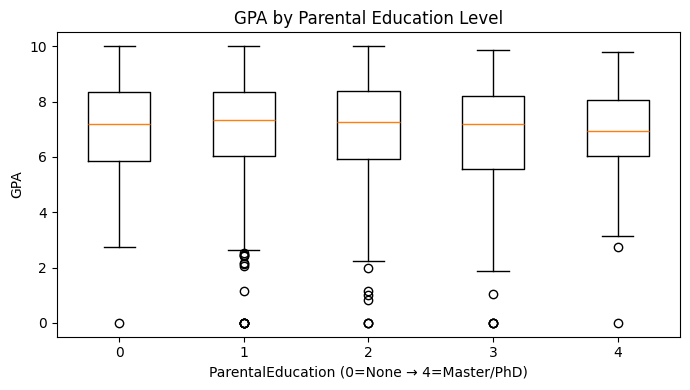

In [53]:
# 4. GPA by ParentalEducation (boxplot)
groups = [df_clean[df_clean['ParentalEducation']==lvl]['GPA'].astype(float).values for lvl in range(0,5)]
plt.figure(figsize=(7,4))
plt.boxplot(groups, labels=[str(i) for i in range(0,5)])
plt.xlabel('ParentalEducation (0=None → 4=Master/PhD)'); plt.ylabel('GPA'); plt.title('GPA by Parental Education Level')
plt.tight_layout()
plt.savefig(reports/'gpa_by_parentaleducation.png')
plt.show()
plt.close()

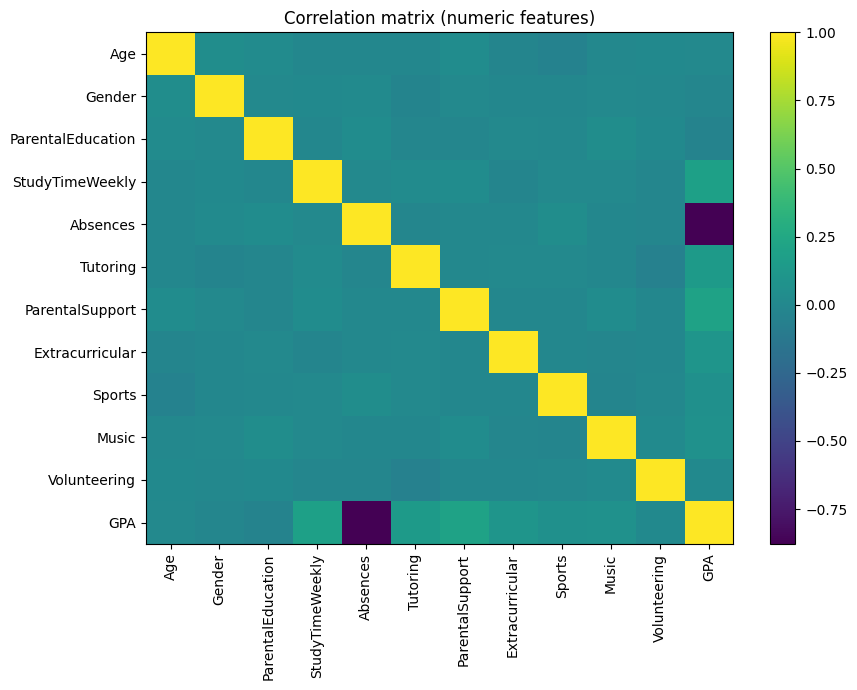

In [54]:
# 5. Correlation matrix (numeric)
corr_cols = ['Age','Gender','ParentalEducation','StudyTimeWeekly','Absences','Tutoring','ParentalSupport',
             'Extracurricular','Sports','Music','Volunteering','GPA']
corr = df_clean[corr_cols].astype(float).corr()

plt.figure(figsize=(9,7))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title('Correlation matrix (numeric features)')
plt.tight_layout()
plt.savefig(reports/'correlation_matrix.png')
plt.show()
plt.close()

In [55]:
# Quick numeric summary printed
print("GPA mean: {:.2f}, median: {:.2f}, min: {:.2f}, max: {:.2f}".format(
    df_clean['GPA'].mean(), df_clean['GPA'].median(), df_clean['GPA'].min(), df_clean['GPA'].max()
))

# Top correlations to GPA (absolute)
corr_to_gpa = corr['GPA'].drop('GPA').abs().sort_values(ascending=False)
print("\nTop correlations to GPA (abs):")
print(corr_to_gpa.head(10))

GPA mean: 6.99, median: 7.24, min: 0.00, max: 10.00

Top correlations to GPA (abs):
Absences             0.877816
ParentalSupport      0.204626
StudyTimeWeekly      0.190235
Tutoring             0.145969
Extracurricular      0.098522
Music                0.073786
Sports               0.063707
ParentalEducation    0.038152
Gender               0.013842
Volunteering         0.010484
Name: GPA, dtype: float64


In [60]:
# Quick data sanity checks
print("Nulls per column:\n", df_clean.isnull().sum())
print("GPA unique values extremes:", df_clean['GPA'].min(), df_clean['GPA'].max())
print("Rows with GPA==0:", (df_clean['GPA'] == 0).sum())
display(df_clean[df_clean['GPA'] == 0].head())

Nulls per column:
 Age                  0
Gender               0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
dtype: int64
GPA unique values extremes: 0.0 10.0
Rows with GPA==0: 16


,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
87,15,0,1,0.008031,27,0,1,0,0,1,0,0.0
474,17,1,2,1.444587,24,0,0,0,0,0,0,0.0
484,15,1,3,0.767231,29,0,0,0,0,0,0,0.0
629,17,1,0,2.139825,28,0,1,1,0,1,0,0.0
879,15,0,2,7.952700,25,0,0,0,0,0,0,0.0


## Feature engineering

Current dataset encodings are:
- Gender: 0/1
- ParentalEducation: 0..4 (ordinal)
- Tutoring, Extracurricular, Sports, Music, Volunteering: 0/1
- ParentalSupport: 0..4 (ordinal)

Notes:
- We assume ordinal encoding for parental education and parental support is meaningful.
- No extra features are strictly required, but we can later add interaction terms like `StudyTimeWeekly * ParentalSupport`.


## Modeling plan

We will:
- Use pipelines with StandardScaler + model (keeps preprocessing consistent)
- Train Linear Regression, Decision Tree Regressor, Random Forest Regressor
- Use KFold cross-validation (n_splits=5) to validate training behavior
- Evaluate on a held-out test set (80/20 split) using R², MAE, RMSE
- Save the best model pipeline with Pickle


In [56]:
# Modeling & evaluation
feature_cols = [c for c in df_clean.columns if c != 'GPA']
X = df_clean[feature_cols].astype(float)
y = df_clean['GPA'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# Pipelines
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipeline_dt = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeRegressor(random_state=RANDOM_STATE))])
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=RANDOM_STATE))])

# Define the parameter grid to search over
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Set up GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Cross-validated R2 on training set
cv_lr = cross_val_score(pipeline_lr, X_train, y_train, scoring='r2', cv=cv)
cv_dt = cross_val_score(pipeline_dt, X_train, y_train, scoring='r2', cv=cv)

# Fit models
pipeline_lr.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)

# Fit the grid search to find the best model
print("Tuning the Random Forest model with GridSearchCV...")
grid_search.fit(X_train, y_train)
# Get the best model and its parameters
best_rf_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")

Tuning the Random Forest model with GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}
Best cross-validation R² score: 0.9098


In [57]:
# Evaluate on test set
models = {
    'LinearRegression': pipeline_lr,
    'DecisionTree': pipeline_dt,
    'RandomForest': best_rf_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    # Calculate cross-validation score for the tuned model
    if name == 'RandomForest':
        cv_score = grid_search.best_score_
    else:
        cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv).mean()

    results.append({
        'model': name,
        'test_R2': r2,
        'cv_R2': cv_score,
        'MAE': mae,
        'RMSE': rmse
    })

results_df = pd.DataFrame(results).sort_values(by='RMSE')
display(results_df)

,model,test_R2,cv_R2,MAE,RMSE
2,RandomForest,0.895287,0.909798,0.370285,0.557132
0,LinearRegression,0.891207,0.889701,0.394778,0.567882
1,DecisionTree,0.815721,0.792097,0.528205,0.739087


In [58]:
# Save the best model pipeline (Pickle)
best_row = results_df.iloc[0]
best_model_name = best_row['model']
best_model_pipeline = models[best_model_name]

MODELS_DIR.mkdir(exist_ok=True)
save_path = MODELS_DIR / 'model.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Saved best model: {best_model_name} to {save_path}")


Saved best model: RandomForest to /content/drive/MyDrive/Student_Performance_Prediction/model/model.pkl


## Conclusion & Limitations

- Check `reports/` for saved plots and images.
- Check `models/model.pkl` for the saved pipeline (preprocessing + model).
- Which features most strongly influence GPA? See correlation matrix and top correlations printed earlier.
- How do absences, study time, parental support impact GPA? The correlation matrix and scatter plots should provide the answer:
  - **Absences**: strong negative relation to GPA
  - **StudyTimeWeekly**: positive, moderate relation
  - **ParentalSupport/ParentalEducation**: positive but weaker
- Limitations:
  - Ordinal encoding for parental fields assumes monotonic effect
  - Dataset size or skew could affect model generalization